# Chapter 5. The mechanics of learning

## Imports

In [1]:
import torch
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

## Parameter estimation

In [2]:
# c = celsius
# u = unknown
t_c = [ 0.5, 14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

# hypothesize a linear model
# t_c = w * t_u + b

## Defining a loss function

In [3]:
def model(t_u, w, b):
    """
    parameters:
        - t_u <torch.Tensor>: input tensor
        - w <torch.Tensor (1,)>: weight parameter
        - b <torch.Tensor (1,)>: bias parameter
    """
    return w * t_u + b

def loss_fn(t_p, t_c):
    """
    t_p <torch.Tensor>: tensor of predicted temperatures
    t_c <torch.Tensor>: tensor of measured temperatures in Celsius
    """
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

In [4]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
print(t_p)

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])


In [5]:
loss = loss_fn(t_p, t_c)
print(loss)

tensor(1763.8848)


## Gradient descent

In [6]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

learning_rate = 1e-2

loss_rate_of_change_b = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

w = w - learning_rate * loss_rate_of_change_w
b = b - learning_rate * loss_rate_of_change_b

In [7]:
def dloss_fn(t_p, t_c): # d(loss) / d t_p
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

In [8]:
def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

In [9]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    
    return torch.stack([dloss_dw.sum(), dloss_db.sum()]) # sum because parameters were broadcast when calculating t_p

### Training loop

In [10]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        
        # forward pass
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        
        # backward pass
        grad = grad_fn(t_u, t_c, t_p, w, b)
        
        params = params - learning_rate * grad
        
        print(f"Epoch {epoch}, Loss {float(loss)}")
        
        if print_params:
            print(f"    Params: {params}")
            print(f"    Grad: {grad}")
    
    return params

In [11]:
# attempt #1: learning rate too large, losses diverge

training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c
)

Epoch 1, Loss 1763.884765625
    Params: tensor([-44.1730,  -0.8260])
    Grad: tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.5
    Params: tensor([2568.4011,   45.1637])
    Grad: tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.0
    Params: tensor([-148527.7344,   -2616.3931])
    Grad: tensor([15109614.0000,   266155.6875])
Epoch 4, Loss 64915905708032.0
    Params: tensor([8589999.0000,  151310.8906])
    Grad: tensor([-8.7385e+08, -1.5393e+07])
Epoch 5, Loss 2.1713052546105344e+17
    Params: tensor([-4.9680e+08, -8.7510e+06])
    Grad: tensor([5.0539e+10, 8.9023e+08])
Epoch 6, Loss 7.262575831529281e+20
    Params: tensor([2.8732e+10, 5.0610e+08])
    Grad: tensor([-2.9229e+12, -5.1486e+10])
Epoch 7, Loss 2.429183416467663e+24
    Params: tensor([-1.6617e+12, -2.9270e+10])
    Grad: tensor([1.6904e+14, 2.9776e+12])
Epoch 8, Loss 8.125122549611731e+27
    Params: tensor([9.6102e+13, 1.6928e+12])
    Grad: tensor([-9.7764e+15, -1.7221e+14])
Epoch 9, Loss 2.717

tensor([nan, nan])

In [12]:
# attempt #2: smaller learning rate
# problem: learning stalls, loss doesn't decrease quickly

training_loop(
    n_epochs = 100,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c
)

Epoch 1, Loss 1763.884765625
    Params: tensor([ 0.5483, -0.0083])
    Grad: tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.09051513671875
    Params: tensor([ 0.3623, -0.0118])
    Grad: tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.92963409423828
    Params: tensor([ 0.2858, -0.0135])
    Grad: tensor([765.4666,  16.5122])
Epoch 4, Loss 37.5528450012207
    Params: tensor([ 0.2543, -0.0143])
    Grad: tensor([315.0790,   8.5787])
Epoch 5, Loss 30.540283203125
    Params: tensor([ 0.2413, -0.0149])
    Grad: tensor([129.6733,   5.3127])
Epoch 6, Loss 29.351154327392578
    Params: tensor([ 0.2360, -0.0153])
    Grad: tensor([53.3495,  3.9682])
Epoch 7, Loss 29.148883819580078
    Params: tensor([ 0.2338, -0.0156])
    Grad: tensor([21.9304,  3.4148])
Epoch 8, Loss 29.113847732543945
    Params: tensor([ 0.2329, -0.0159])
    Grad: tensor([8.9964, 3.1869])
Epoch 9, Loss 29.107145309448242
    Params: tensor([ 0.2325, -0.0162])
    Grad: tensor([3.6721, 3.0930])
Epoch 10, Loss 29.1

tensor([ 0.2327, -0.0438])

### Normalizing inputs

In [13]:
# gradients of each parameter are differently scaled; the means
# that the learning rate might be stable for one parameter, but
# not another
#
# instead, normalize inputs so that all parameters live on same scale

t_un = 0.1 * t_u

params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,  # back to 1e-2
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un, # normalized unknown values
    t_c = t_c,
    print_params=False
)

Epoch 1, Loss 80.36434173583984
Epoch 2, Loss 37.574913024902344
Epoch 3, Loss 30.871076583862305
Epoch 4, Loss 29.756193161010742
Epoch 5, Loss 29.507152557373047
Epoch 6, Loss 29.3924560546875
Epoch 7, Loss 29.298828125
Epoch 8, Loss 29.208717346191406
Epoch 9, Loss 29.119415283203125
Epoch 10, Loss 29.030488967895508
Epoch 11, Loss 28.941877365112305
Epoch 12, Loss 28.853565216064453
Epoch 13, Loss 28.765552520751953
Epoch 14, Loss 28.6778507232666
Epoch 15, Loss 28.590431213378906
Epoch 16, Loss 28.503318786621094
Epoch 17, Loss 28.4164981842041
Epoch 18, Loss 28.329973220825195
Epoch 19, Loss 28.243741989135742
Epoch 20, Loss 28.157804489135742
Epoch 21, Loss 28.07215118408203
Epoch 22, Loss 27.986797332763672
Epoch 23, Loss 27.9017276763916
Epoch 24, Loss 27.81694984436035
Epoch 25, Loss 27.732463836669922
Epoch 26, Loss 27.648256301879883
Epoch 27, Loss 27.56434440612793
Epoch 28, Loss 27.4807071685791
Epoch 29, Loss 27.397361755371094
Epoch 30, Loss 27.314294815063477
Epoch 31,

Epoch 1674, Loss 3.0187063217163086
Epoch 1675, Loss 3.018394708633423
Epoch 1676, Loss 3.0180890560150146
Epoch 1677, Loss 3.017779588699341
Epoch 1678, Loss 3.017474889755249
Epoch 1679, Loss 3.017169713973999
Epoch 1680, Loss 3.016867160797119
Epoch 1681, Loss 3.016563653945923
Epoch 1682, Loss 3.0162618160247803
Epoch 1683, Loss 3.0159590244293213
Epoch 1684, Loss 3.0156617164611816
Epoch 1685, Loss 3.0153610706329346
Epoch 1686, Loss 3.015064001083374
Epoch 1687, Loss 3.014767646789551
Epoch 1688, Loss 3.014472246170044
Epoch 1689, Loss 3.014178991317749
Epoch 1690, Loss 3.0138838291168213
Epoch 1691, Loss 3.0135910511016846
Epoch 1692, Loss 3.0132994651794434
Epoch 1693, Loss 3.013007879257202
Epoch 1694, Loss 3.012718915939331
Epoch 1695, Loss 3.0124306678771973
Epoch 1696, Loss 3.0121407508850098
Epoch 1697, Loss 3.011855125427246
Epoch 1698, Loss 3.0115699768066406
Epoch 1699, Loss 3.0112838745117188
Epoch 1700, Loss 3.0110013484954834
Epoch 1701, Loss 3.01071834564209
Epoch 1

Epoch 2231, Loss 2.9413461685180664
Epoch 2232, Loss 2.941298723220825
Epoch 2233, Loss 2.9412527084350586
Epoch 2234, Loss 2.941206455230713
Epoch 2235, Loss 2.9411628246307373
Epoch 2236, Loss 2.941115617752075
Epoch 2237, Loss 2.9410698413848877
Epoch 2238, Loss 2.9410247802734375
Epoch 2239, Loss 2.940978765487671
Epoch 2240, Loss 2.9409332275390625
Epoch 2241, Loss 2.940889596939087
Epoch 2242, Loss 2.9408440589904785
Epoch 2243, Loss 2.940798282623291
Epoch 2244, Loss 2.940753221511841
Epoch 2245, Loss 2.9407105445861816
Epoch 2246, Loss 2.9406661987304688
Epoch 2247, Loss 2.9406211376190186
Epoch 2248, Loss 2.9405760765075684
Epoch 2249, Loss 2.940532922744751
Epoch 2250, Loss 2.9404892921447754
Epoch 2251, Loss 2.9404456615448
Epoch 2252, Loss 2.9404027462005615
Epoch 2253, Loss 2.9403581619262695
Epoch 2254, Loss 2.9403159618377686
Epoch 2255, Loss 2.940274238586426
Epoch 2256, Loss 2.9402289390563965
Epoch 2257, Loss 2.940187692642212
Epoch 2258, Loss 2.940143585205078
Epoch 

Epoch 2640, Loss 2.93105411529541
Epoch 2641, Loss 2.931044101715088
Epoch 2642, Loss 2.9310340881347656
Epoch 2643, Loss 2.931021213531494
Epoch 2644, Loss 2.9310102462768555
Epoch 2645, Loss 2.9309990406036377
Epoch 2646, Loss 2.9309868812561035
Epoch 2647, Loss 2.930976152420044
Epoch 2648, Loss 2.930964469909668
Epoch 2649, Loss 2.93095326423645
Epoch 2650, Loss 2.930940866470337
Epoch 2651, Loss 2.930931806564331
Epoch 2652, Loss 2.9309206008911133
Epoch 2653, Loss 2.930907964706421
Epoch 2654, Loss 2.930899143218994
Epoch 2655, Loss 2.930885076522827
Epoch 2656, Loss 2.9308760166168213
Epoch 2657, Loss 2.930863380432129
Epoch 2658, Loss 2.930853843688965
Epoch 2659, Loss 2.9308412075042725
Epoch 2660, Loss 2.930832624435425
Epoch 2661, Loss 2.930821418762207
Epoch 2662, Loss 2.9308106899261475
Epoch 2663, Loss 2.9308013916015625
Epoch 2664, Loss 2.930788278579712
Epoch 2665, Loss 2.9307777881622314
Epoch 2666, Loss 2.9307668209075928
Epoch 2667, Loss 2.9307572841644287
Epoch 2668

Epoch 3156, Loss 2.928236246109009
Epoch 3157, Loss 2.9282326698303223
Epoch 3158, Loss 2.9282312393188477
Epoch 3159, Loss 2.928230047225952
Epoch 3160, Loss 2.928227424621582
Epoch 3161, Loss 2.9282257556915283
Epoch 3162, Loss 2.928224802017212
Epoch 3163, Loss 2.928222417831421
Epoch 3164, Loss 2.9282188415527344
Epoch 3165, Loss 2.928218126296997
Epoch 3166, Loss 2.928215980529785
Epoch 3167, Loss 2.9282150268554688
Epoch 3168, Loss 2.9282121658325195
Epoch 3169, Loss 2.928210973739624
Epoch 3170, Loss 2.928209066390991
Epoch 3171, Loss 2.928206443786621
Epoch 3172, Loss 2.9282050132751465
Epoch 3173, Loss 2.928203582763672
Epoch 3174, Loss 2.928201913833618
Epoch 3175, Loss 2.9282000064849854
Epoch 3176, Loss 2.9281961917877197
Epoch 3177, Loss 2.928194522857666
Epoch 3178, Loss 2.928194522857666
Epoch 3179, Loss 2.9281914234161377
Epoch 3180, Loss 2.928189992904663
Epoch 3181, Loss 2.9281883239746094
Epoch 3182, Loss 2.9281859397888184
Epoch 3183, Loss 2.928184747695923
Epoch 31

Epoch 4838, Loss 2.9276468753814697
Epoch 4839, Loss 2.9276483058929443
Epoch 4840, Loss 2.9276468753814697
Epoch 4841, Loss 2.927649736404419
Epoch 4842, Loss 2.9276483058929443
Epoch 4843, Loss 2.927647590637207
Epoch 4844, Loss 2.9276487827301025
Epoch 4845, Loss 2.9276468753814697
Epoch 4846, Loss 2.9276468753814697
Epoch 4847, Loss 2.9276483058929443
Epoch 4848, Loss 2.9276468753814697
Epoch 4849, Loss 2.927647590637207
Epoch 4850, Loss 2.927647352218628
Epoch 4851, Loss 2.9276487827301025
Epoch 4852, Loss 2.927647590637207
Epoch 4853, Loss 2.927647590637207
Epoch 4854, Loss 2.9276487827301025
Epoch 4855, Loss 2.9276468753814697
Epoch 4856, Loss 2.9276480674743652
Epoch 4857, Loss 2.927647352218628
Epoch 4858, Loss 2.9276483058929443
Epoch 4859, Loss 2.9276480674743652
Epoch 4860, Loss 2.927647352218628
Epoch 4861, Loss 2.9276483058929443
Epoch 4862, Loss 2.927645206451416
Epoch 4863, Loss 2.9276483058929443
Epoch 4864, Loss 2.927647590637207
Epoch 4865, Loss 2.9276466369628906
Ep

## Visualization

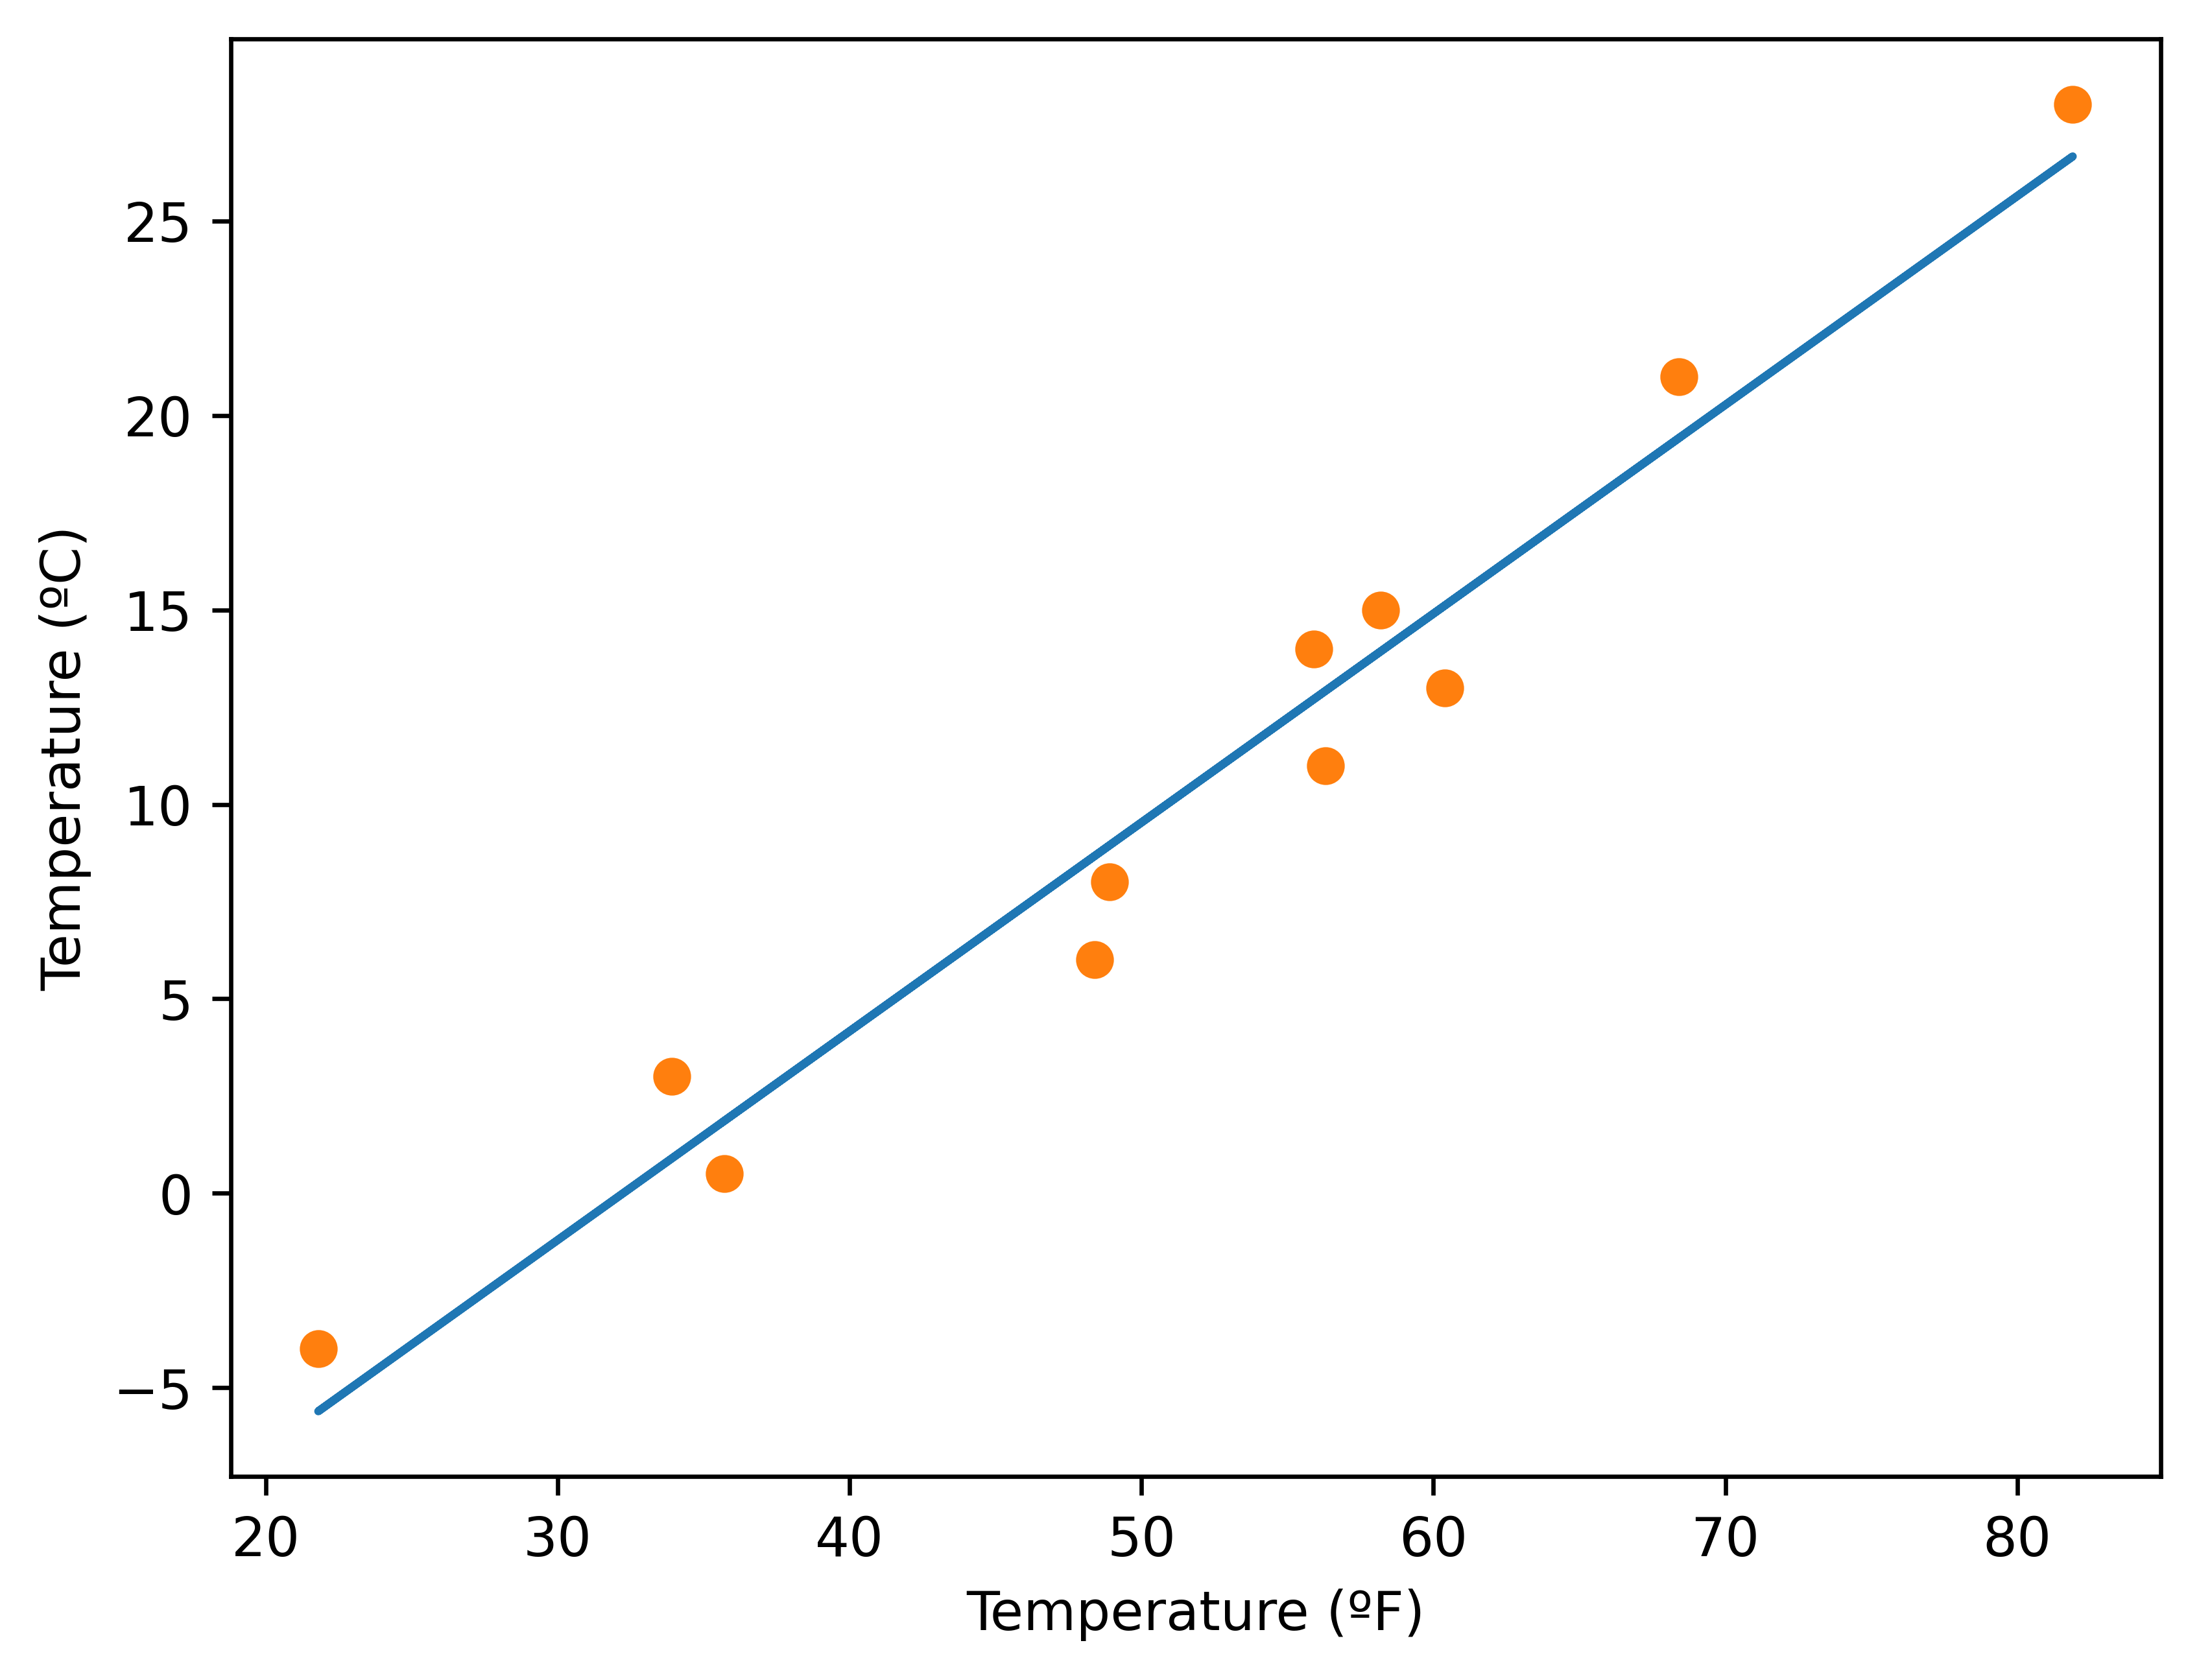

In [14]:
# model trained on normalized units, but outputs unnormalized predictions
t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (ºF)")
plt.ylabel("Temperature (ºC)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.scatter(t_u.numpy(), t_c.numpy(), c="C1")

## Autograd

In [15]:
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

In [16]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [17]:
params.grad is None

True

In [18]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

print(params.grad)

tensor([4517.2969,   82.6000])


In [19]:
if params.grad is not None:
    params.grad.zero_()

In [20]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss {float(loss)}")
    
    return params

In [21]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c
)

Epoch 500, Loss 7.860115051269531
Epoch 1000, Loss 3.828537940979004
Epoch 1500, Loss 3.092191219329834
Epoch 2000, Loss 2.957697868347168
Epoch 2500, Loss 2.933133840560913
Epoch 3000, Loss 2.9286484718322754
Epoch 3500, Loss 2.9278297424316406
Epoch 4000, Loss 2.9276793003082275
Epoch 4500, Loss 2.927651882171631
Epoch 5000, Loss 2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

## Optimizers

In [22]:
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

### Gradient descent optimizer

In [23]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)


t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

print(params)

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)


In [24]:
# no more learning rate; all encapsulated by optimizer

def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss {float(loss)}")
            
    return params

In [25]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    params=params,
    t_u=t_un,
    t_c=t_c
)

Epoch 500, Loss 7.860115051269531
Epoch 1000, Loss 3.828537940979004
Epoch 1500, Loss 3.092191219329834
Epoch 2000, Loss 2.957697868347168
Epoch 2500, Loss 2.933133840560913
Epoch 3000, Loss 2.9286484718322754
Epoch 3500, Loss 2.9278297424316406
Epoch 4000, Loss 2.9276793003082275
Epoch 4500, Loss 2.927651882171631
Epoch 5000, Loss 2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

### Other optimizers

In [26]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    params=params,
    t_u=t_u,
    t_c=t_c
)

Epoch 500, Loss 7.612900257110596
Epoch 1000, Loss 3.086700439453125
Epoch 1500, Loss 2.928579092025757
Epoch 2000, Loss 2.9276442527770996
Epoch 2500, Loss 2.927645206451416
Epoch 3000, Loss 2.9276459217071533
Epoch 3500, Loss 2.927644968032837
Epoch 4000, Loss 2.927645683288574
Epoch 4500, Loss 2.9276463985443115
Epoch 5000, Loss 2.927645206451416


tensor([  0.5368, -17.3048], requires_grad=True)

## Training, validation, and overfitting

### Splitting a dataset

In [27]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

print(train_indices, val_indices)

tensor([ 9,  8,  0,  7,  5, 10,  2,  6,  1]) tensor([3, 4])


In [28]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [31]:
# add:
# 1. calculate validation loss at every epoch

def training_loop(n_epochs,
                  optimizer,
                  params,
                  train_t_u,
                  val_t_u,
                  train_t_c,
                  val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad(): # save computation by not building the backprop graph
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
        
        optimizer.zero_grad()
        train_loss.backward()
        # no val_loss.backward(); we don't want to train on the validation set
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
    
    return params

In [32]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    params=params,
    train_t_u=train_t_un, # use normalized values for SGD
    val_t_u=val_t_un,
    train_t_c=train_t_c,
    val_t_c=val_t_c
)

Epoch 1, Training loss 51.4150, Validation loss 210.6365
Epoch 2, Training loss 30.8837, Validation loss 122.4504
Epoch 3, Training loss 26.0599, Validation loss 89.7899
Epoch 500, Training loss 7.6853, Validation loss 20.7935
Epoch 1000, Training loss 3.9516, Validation loss 8.9512
Epoch 1500, Training loss 3.1379, Validation loss 5.4303
Epoch 2000, Training loss 2.9606, Validation loss 4.2241
Epoch 2500, Training loss 2.9219, Validation loss 3.7563
Epoch 3000, Training loss 2.9135, Validation loss 3.5587


tensor([  5.1676, -16.2686], requires_grad=True)